# Analysis of existing installations
The goal of this notebook find new features that could help inestigating

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from urllib.parse import urlparse
import pymysql
import os
import importlib
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

import numpy as np

from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

importlib.reload(sns)

<module 'seaborn' from '/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/seaborn/__init__.py'>

## data loading
input:
- set of features from hubspot
- set of features and savings calculation from internal api
- daily aggregated values of cics
- cic production dataset, to link cic id to ordernumber

Output:
df_cic: 1 row is 1 day of data, all features of a cic(installation) are merged onto that frame

In [3]:
# get data from mysql or local
if os.path.isfile('./data/cic_data.csv'):
    # load csv file
    df_cic = pd.read_csv('./data/cic_data.csv')

else:
    MYSQL_URL = os.environ['MYSQLDEV']
    parsed_mysql_url = urlparse(MYSQL_URL)

    try:
        connection = pymysql.connect(host=parsed_mysql_url.hostname,
                                    user=parsed_mysql_url.username,
                                    password=parsed_mysql_url.password,
                                    database=parsed_mysql_url.path[1:],
                                    port=parsed_mysql_url.port,
                                    autocommit=True)
        cursor = connection.cursor()
        if cursor.connection:
            # get energyConsumption
            cursor.execute('''SELECT * FROM cic_data_daily''')
            fields = [field_md[0] for field_md in cursor.description]
            result = [dict(zip(fields,row)) for row in cursor.fetchall()]
            df_cic = pd.DataFrame(result)
            df_cic.to_csv('./data/cic_data.csv', index=False)
    except:
        print("Error while connecting to MySQL")
    finally:
        cursor.close()
        connection.close()

In [4]:
# load expected savings data:
df_savings = pd.read_csv('./data/EnergyConsumption_test_data2.csv')
df_hubspot = pd.read_csv('./data/hubspot_data.csv')
df_cic_prod = pd.read_csv('./data/prod_cic.csv')

# merge df_savings with df_cic
df_hubspot['orderNr'] = df_hubspot['Deal Name'].str.extract(r'.*(QUATT\d+)')
df_savings = pd.merge(df_savings, df_cic_prod, left_on='orderNr', right_on='orderNumber', how='left')
df_savings = pd.merge(df_savings, df_hubspot, left_on='orderNr', right_on='orderNr', how='left')
df_cic = pd.merge(df_cic, df_savings, left_on='cic_id', right_on='id_y', how='left')



## Enriching the data

Addition of calculated values: COP, heat generated etc.  



In [5]:
df_cic['date'] = pd.to_datetime(df_cic['date'], format='%Y-%m-%d')

# add heat demand and month to dataframe
df_cic['heat_delivered'] = df_cic[['hp1_heat_generated', 'hp2_heat_generated', 'boiler_heat_generated']].sum(axis=1).astype(float)
df_cic['hp_heat_generated'] = df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1).astype(float)
df_cic['hp_energy_consumed'] = df_cic[['hp1_energy_consumed', 'hp2_energy_consumed']].sum(axis=1).astype(float)
df_cic['perc_by_hp'] = (df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1) / df_cic['heat_delivered']).astype(float)
df_cic['COP'] = (df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1) / (df_cic[['hp1_energy_consumed', 'hp2_energy_consumed']].sum(axis=1))).astype(float)
df_cic['month'] = df_cic['date'].dt.month
df_cic['dd_month'] = df_cic['month'].apply(lambda x: 0.8 if x in [4, 5, 6, 7, 8, 9] else (1 if x in [3, 10] else 1.1)) # month weight factor as used in degree days method
df_cic['aardgas_verbruik_cat'] = df_cic['aardgas_verbruik'].apply(lambda x: 0 if x < 1000 else (1 if x < 2000 else (2 if x < 3000 else 3)))
df_cic['outside_temperature_avg'] = df_cic['outside_temperature_avg'].astype(float)

## preprocessing

Imputation: 
- Missing values: numberOfHeatPumps = 1, 'Zone regeling'=Nee  

Merging values:
- Weet niet, weet ik niet, none -> unknown
- Bouwjaar in 4 categories

Ordinal encoding:
- added ordinal encoding column for woning_type, zone_regeling, bouwjaar

One hot encoding:
- added OH encoding for afgiftesysteem, woningcomfort (because they can have multiple values)

In [6]:
# filling Nan values
df_cic['numberOfHeatPumps'].fillna(1, inplace=True)
df_cic['Zone regeling'].fillna('Nee', inplace=True)

# preprocess hubspot data
# merge 'Weet niet' and 'Weet ik niet' and 'nan' values to -> unkown
replacement_dict = {None: 'unknown', 
                    'Weet niet': 'unknown',
                    'Weet ik niet': 'unknown'}
df_cic.replace({'Spouwmuurisolatie': replacement_dict,
                    'Muurisolatie aan de binnen- of buitenkant': replacement_dict,
                    'Dakisolatie': replacement_dict,
                    'Vloerisolatie': replacement_dict,
                    'Dubbel glas': replacement_dict,
                    'HR++ glas': replacement_dict,
                    }, inplace=True)

# rename long column
df_cic.rename(columns={'Muurisolatie aan de binnen- of buitenkant': 'Muurisolatie'}, inplace=True)

# add ordinal encoding for categorical variables
df_cic['woning_type_ordinal'] = df_cic['woning_type'].map({'Vrijstaande woning': 0,
                                         '2-onder-1-kap': 1,
                                         'Hoekwoning': 2,
                                         'Tussenwoning': 3,
                                         'Appartement': 4})

df_cic['Zone_regeling_ordinal'] = df_cic['Zone regeling'].map({'Nee': 0,
                                             'Ja': 1,
                                             None: 0})

df_cic['bouwjaar'] = df_cic['bouwjaar'].map({'Voor 1970': 'Voor 1970',
                                            'voor 1970': 'Voor 1970',
                                            'Tussen 1970 en 1990': 'Tussen 1970 en 1990',
                                            '1970-1990': 'Tussen 1970 en 1990',
                                            '1974': 'Tussen 1970 en 1990',
                                            '1980': 'Tussen 1970 en 1990',
                                            'Tussen 1990 en 2000': 'Tussen 1990 en 2000',
                                            'Tussen 1995': 'Tussen 1990 en 2000',
                                            'Na 2000': 'Na 2000',
                                            '2000': 'Na 2000',
                                            '2005': 'Na 2000',
                                            '2010': 'Na 2000'})
df_cic['bouwjaar_ordinal'] = df_cic['bouwjaar'].map({'Voor 1970': 0,
                                   'Tussen 1970 en 1990': 1,
                                   'Tussen 1990 en 2000': 2,
                                   'Na 2000': 3})

# One hot encoding for categorical variables with multiple values
df_cic = pd.merge(df_cic, df_cic['afgiftesysteem'].str.replace('; ',';').str.get_dummies(sep=';'), left_index=True, right_index=True)
df_cic = pd.merge(df_cic, df_cic['Woning comfort'].str.replace('; ',';').str.get_dummies(sep=';'), left_index=True, right_index=True)


## visualisation


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


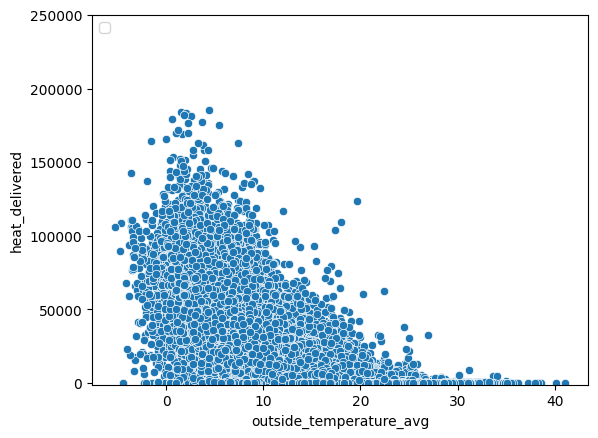

In [14]:


# scatter plot of heat demand per temperature including linear regression
sns.scatterplot(x='outside_temperature_avg', y='heat_delivered', data=df_cic)
plt.legend(loc='upper left')
plt.ylim([-1000, 250000])
plt.show()

(-0.1, 1.1)

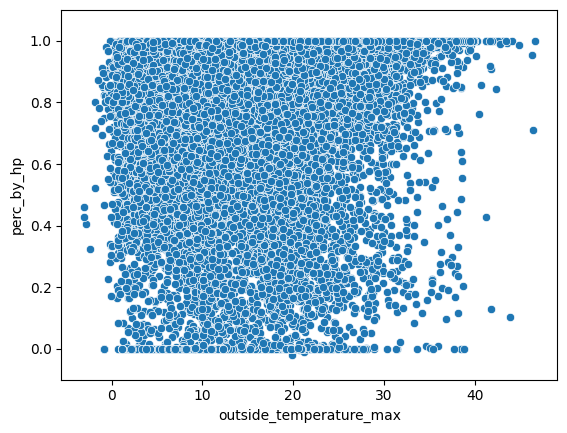

In [15]:
# scatter plot of perc_by_hp per temperature
sns.scatterplot(x='outside_temperature_max', y='perc_by_hp', 
           data=df_cic[df_cic['heat_delivered']>1000])
plt.ylim([-0.1, 1.1])

(0.0, 10.0)

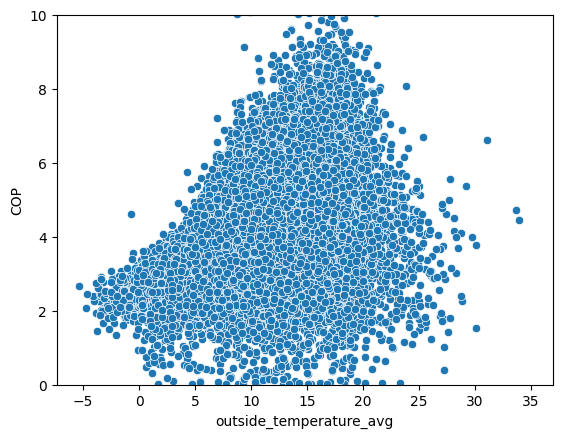

In [17]:
# scatter plot of COP per temperature
COP_temp = sns.scatterplot(x='outside_temperature_avg', y='COP', 
           data=df_cic[(df_cic['COP']>0) & (df_cic['heat_delivered']>1000)])
plt.ylim([0,10])

## Cleaning of data
- Selecting a subset of features (columns)
- select a set of cics for which days of heating > 50
- select those where certain values are not zero

In [19]:
# get a subset of cic_data with cic's that have enough rows with non zero heat generated
df_cic_subset = df_cic[['cic_id',
                        'maximumHeatingOutdoorTemperature',
                        'ratedMaximumHousePower',
                        'date',
                        'heat_delivered',
                        'hp_heat_generated',
                        'hp_energy_consumed',
                        'perc_by_hp',
                        'COP',
                        'outside_temperature_avg',
                        'outside_temperature_min',
                        'outside_temperature_max',
                        'room_set_temperature_max',
                        'room_set_temperature_avg',
                        'room_set_temperature_min',
                        'room_temperature_max',
                        'room_temperature_avg',
                        'room_temperature_min',
                        'numberOfHeatPumps',
                        'aardgas_verbruik',
                        'bouwjaar',
                        'woning_type',  
                        'oppervlakte',
                        'afgiftesysteem',
                        'geschiktheidscategorie',
                        'Zone regeling',
                        'month']]

# add count of rows where heat_delivered > 0 per cic
df_cic_subset['rows_per_cic_heating'] = df_cic_subset.groupby('cic_id')['heat_delivered'].transform(lambda x: x[x>0].count())
df_cic_subset = df_cic_subset[df_cic_subset['rows_per_cic_heating']>50]
# drop rows where tempearature avg is nan
df_cic_subset = df_cic_subset[df_cic_subset['outside_temperature_avg'].notna()]

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_82551/43802628.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cic_subset['rows_per_cic_heating'] = df_cic_subset.groupby('cic_id')['heat_delivered'].transform(lambda x: x[x>0].count())


## visualisation

- one specific installation: %byhp, COP, HeatDemand.
    - COP and %byhp do not show a very clear linear relationship with average daily temperature (could be caused by that they are more dependant on the hour of heating)

- 

Text(0.5, 1.0, 'heat_delivered per temperature')

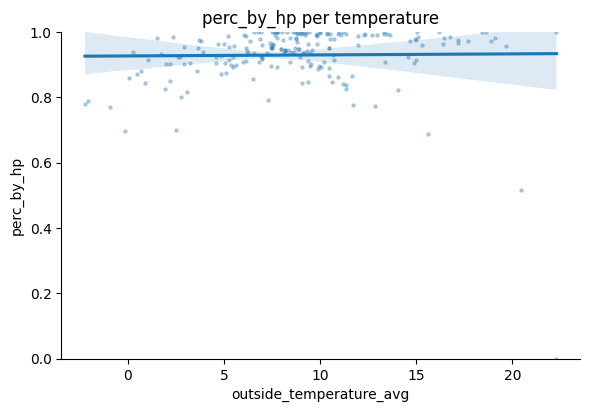

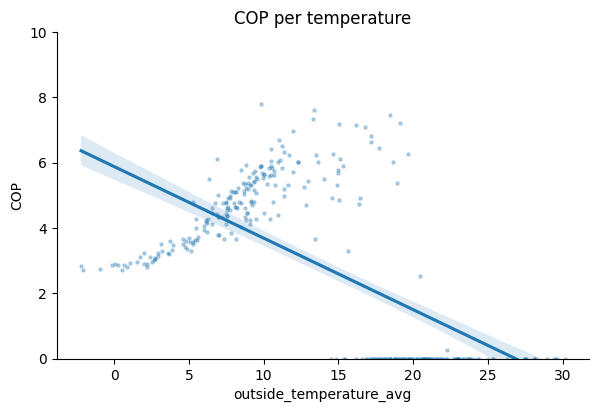

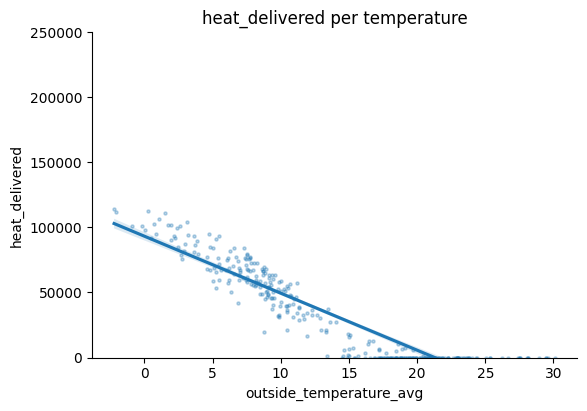

In [21]:
# visualisation of 1 specific installatio

# scatter plot of perc_by_hp per temperature
sns.lmplot(x='outside_temperature_avg', y='perc_by_hp', 
           data=df_cic_subset[df_cic_subset['cic_id']=='CIC-17fcd27d-dbd7-561c-887e-faf59bb9ebeb'], height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.ylim([0, 1])
plt.title('perc_by_hp per temperature')

# scatter plot of COP per temperature
COP_temp = sns.lmplot(x='outside_temperature_avg', y='COP', 
           data=df_cic_subset[df_cic_subset['cic_id']=='CIC-17fcd27d-dbd7-561c-887e-faf59bb9ebeb'], 
             height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.ylim([0,10])
plt.title('COP per temperature')

# scatter plot of heat_delivered per temperature
COP_temp = sns.lmplot(x='outside_temperature_avg', y='heat_delivered', 
           data=df_cic_subset[df_cic_subset['cic_id']=='CIC-17fcd27d-dbd7-561c-887e-faf59bb9ebeb'], 
             height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.ylim([0,250000])
plt.title('heat_delivered per temperature')

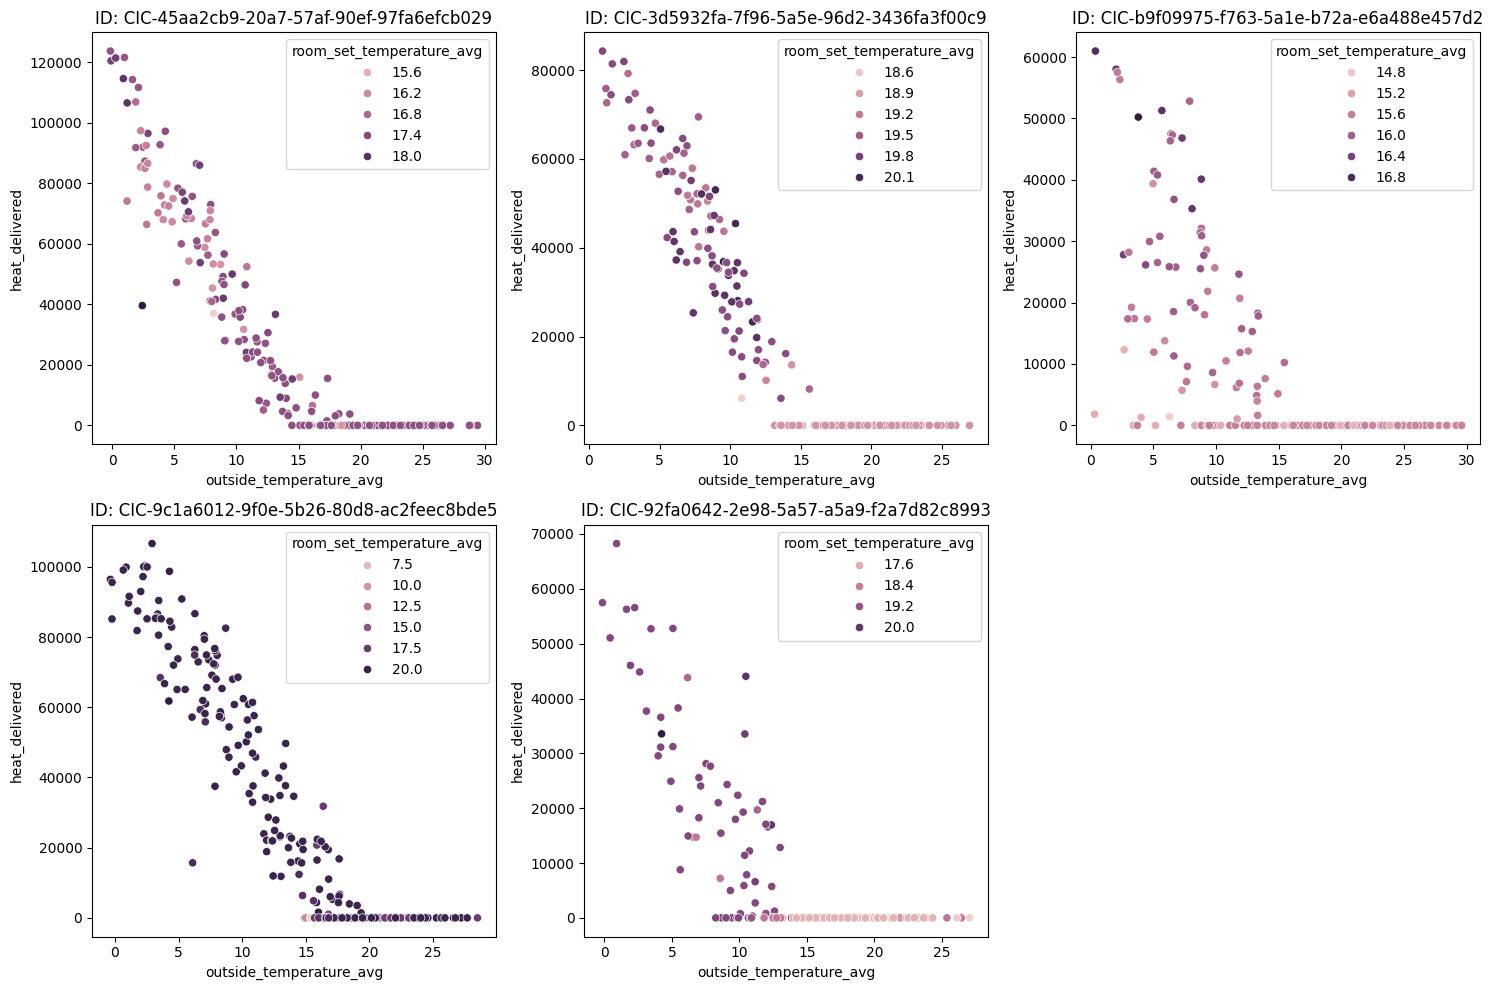

In [22]:
# plot if there is actually a linear relation between heat generated and temperature
# Select a few random device IDs
sample_ids = df_cic_subset['cic_id'].sample(5, random_state=44).tolist()

plt.figure(figsize=(15, 10))

for i, cic in enumerate(sample_ids, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df_cic_subset[df_cic_subset['cic_id'] == cic], 
                    x='outside_temperature_avg', 
                    y='heat_delivered',
                    hue='room_set_temperature_avg')
    # ax2 = plt.twinx()
    # sns.scatterplot(data=df_cic_subset[df_cic_subset['cic_id'] == cic],
    #                 x='outside_temperature_avg',
    #                 y='room_temperature_avg',
    #                 ax=ax2, color='red')
    plt.title(f'ID: {cic}')

plt.tight_layout()
plt.show()

## fit linear curve to outside heat demand vs temperature

In [23]:
from sklearn.linear_model import LinearRegression
# for each cic make a linear fit on the heat delivered vs outside temperature avg
for cicId in df_cic_subset['cic_id'].unique():
    
    X_train = df_cic_subset[(df_cic_subset['cic_id']==cicId) &
                      (df_cic_subset['heat_delivered']!=0)][['outside_temperature_avg']]
    y_train = df_cic_subset[(df_cic_subset['cic_id']==cicId) &
                      (df_cic_subset['heat_delivered']!=0)]['heat_delivered']
    
    reg = LinearRegression().fit(X_train, y_train)
    # print(f'cicId: {cicId}, number_of_points: {nr_of_points}, intercept: {reg.intercept_}, coeff: {reg.coef_[0]}')
    df_cic_subset.loc[df_cic_subset['cic_id']==cicId, 'heat_delivered_intercept'] = reg.intercept_
    df_cic_subset.loc[df_cic_subset['cic_id']==cicId, 'heat_delivered_coeff'] = reg.coef_[0]

# calculate the mae or the linear fit
# df_cic_subset['heat_delivered_mae'] = df_cic_subset.groupby('cic_id').apply(lambda x: metrics.mean_absolute_error(x['heat_delivered'], x['heat_delivered_pred']))
# df_cic_subset['heat_delivered_mse'] = df_cic_subset.groupby('cic_id').apply(lambda x: metrics.mean_squared_error(x['heat_delivered'], x['heat_delivered_pred']))

# replace cic_id by an increasing number
df_cic_subset['cic_id'] = df_cic_subset['cic_id'].astype('category').cat.codes

/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


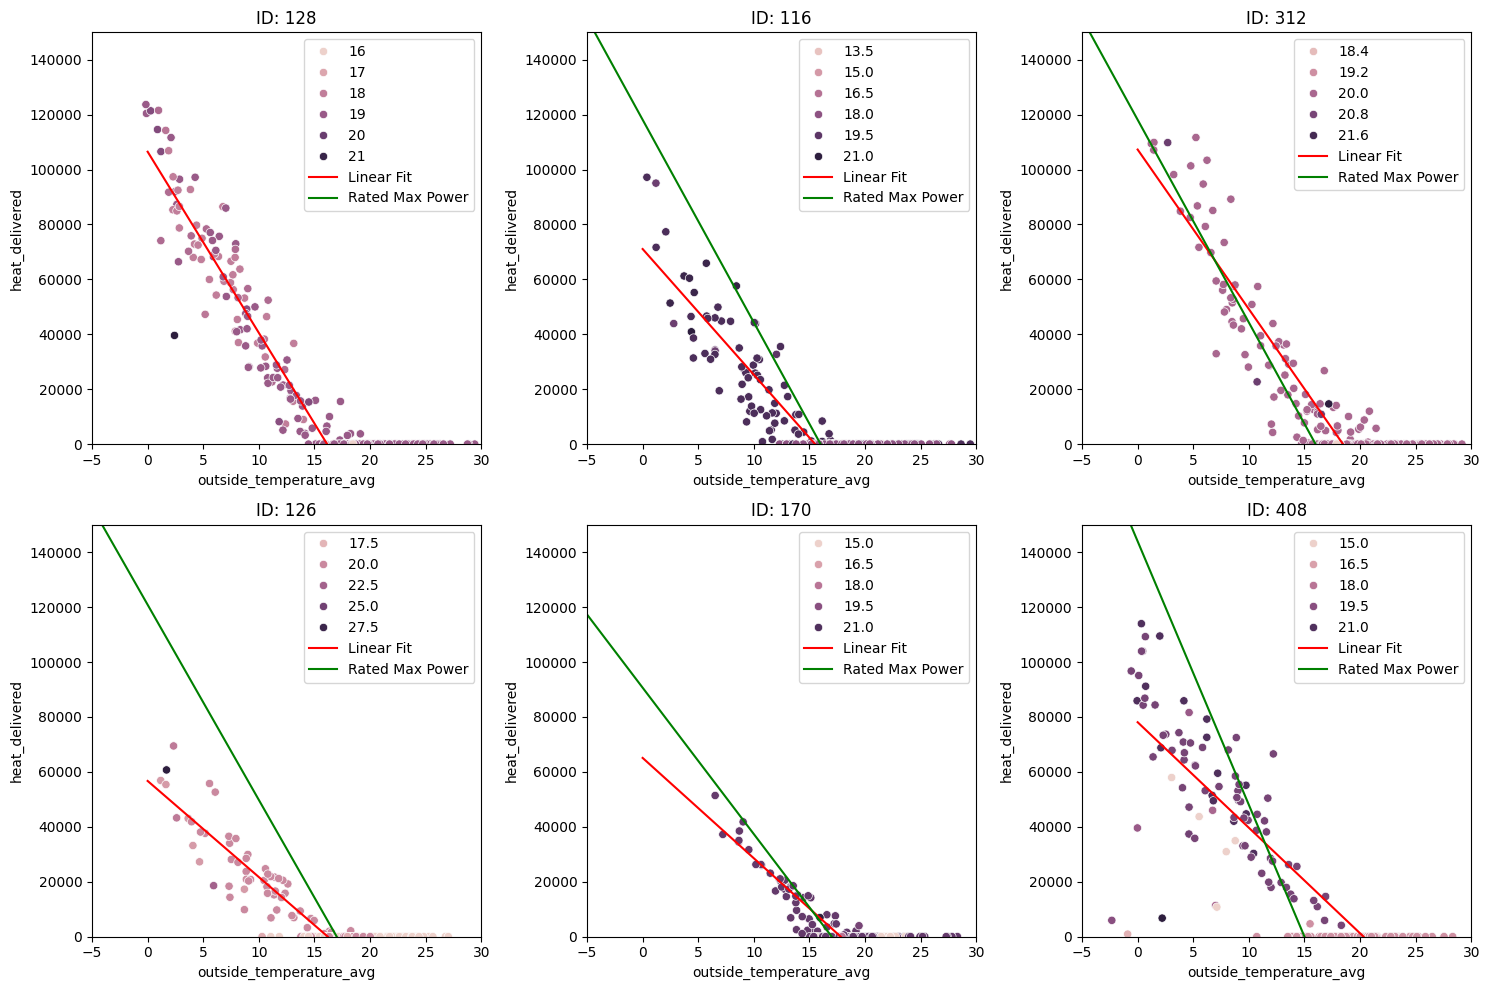

In [24]:
# show linear fit's on random cic'sample_ids# Select a few random device IDs
sample_ids_updated = df_cic_subset['cic_id'].sample(6, random_state=0).tolist()

plt.figure(figsize=(15, 10))

# For each random device ID, plot the scatter and the linear fit
for i, cic in enumerate(sample_ids_updated, 1):
    plt.subplot(2, 3, i)
    
    # Data for the current ID
    data = df_cic_subset[df_cic_subset['cic_id'] == cic]
    coeff = data['heat_delivered_coeff'].iloc[0]
    intercept = data['heat_delivered_intercept'].iloc[0]
    ratedMaximumHousePower = data['ratedMaximumHousePower'].median()
    maximumHeatingOutdoorTemperature = data['maximumHeatingOutdoorTemperature'].median()
    
    # Plot the scatter
    sns.scatterplot(data=data, 
                    x='outside_temperature_avg', 
                    y='heat_delivered',
                    hue='room_set_temperature_max')
    
    # Plot the linear fit
    plt.plot([0,intercept / (-1 * coeff)], [intercept, 0], 
             color='red', label='Linear Fit')
    plt.plot([-10, maximumHeatingOutdoorTemperature], [ratedMaximumHousePower*24, 0], 
             color='green',label='Rated Max Power')
    plt.xlim([-5, 30])
    plt.ylim([0, 150000])
    plt.title(f'ID: {cic}')
    plt.legend()

# correlation between intercept and coefficient
# plt.subplot(2, 3, 6)
# sns.scatterplot(data=df_cic_subset, x='heat_delivered_intercept', y='heat_delivered_coeff')
# plt.xlabel('intercept')
# plt.ylabel('coeff')
# plt.title('intercept vs coeff for all ids')

plt.tight_layout()
plt.show()

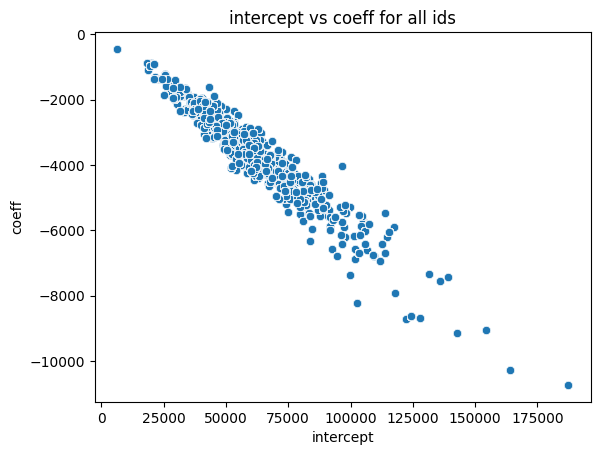

In [25]:
# the intercept and coeff are very correlated.

# scatter the intercept and coeff
sns.scatterplot(data=df_cic_subset, x='heat_delivered_intercept', y='heat_delivered_coeff')
plt.xlabel('intercept')
plt.ylabel('coeff')
plt.title('intercept vs coeff for all ids')
plt.show()

# scatter stookgrens vs rated_house_power_demand